## The magic starts here 

### Some useful tutorials
https://arxiv.org/ftp/arxiv/papers/1510/1510.04863.pdf

https://docs.opencv.org/3.4/d9/db0/tutorial_hough_lines.html

https://theailearner.com/2020/11/20/hough-line-transform/

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
img = cv.imread(r"92f878e2-fff8-448d-bb64-14eb79ef9d8f.jpg")

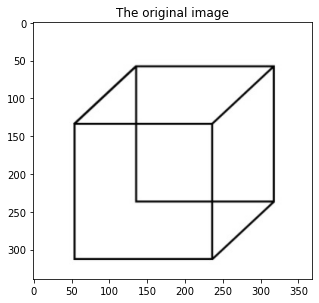

In [3]:
plt.figure(figsize=(5, 5))
plt.imshow(img)
plt.title("The original image")
plt.show()

In [4]:
#The following function is to get the edges of your picture as well as the gradeints in both x and y directions.
def CannyandGradients(image, thr1, thr2):
    edges = cv.Canny(image,thr1,thr2)
    sobelx = cv.Sobel(image,cv.CV_64F,1,0,ksize=5)
    sobely = cv.Sobel(image,cv.CV_64F,0,1,ksize=5)
    return edges, sobelx, sobely

#The is function mainly is to get the rho, theta and the accumulation function.
def Hough(image):
    
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY) #To deal with our image as a gray image not colored.
    edges, Gx, Gy = CannyandGradients(gray, 190, 200) #Get the edges and the gradients of our picture in both x and y directions.
    #I just want to emphasize that here we want to get the edges of our picutre because these represent the lines that I want to get their equations.
    
    x, y = np.meshgrid(range(gray.shape[1]), range(gray.shape[0])) #Using a meshgrid to use in calculaing rho in our equation.
    theta = np.arctan2(Gy, Gx) #Theta equation.
    rho = x * np.cos(theta) + y * np.sin(theta) #Rho equation.

    number_of_r_samples = edges.shape[0] #Number of steps to map the range of rhos to it(Quantization).
    number_of_theta_samples = edges.shape[1] #Number of steps to map the range of thetas to it(Quantization).
    H = np.zeros((number_of_r_samples, number_of_theta_samples)) #Intializing the accumulation array with zeros.
    
    x_max = edges.shape[0] #The number of rows.
    y_max = edges.shape[1] #The number of columns.
    
    r_min = 0.0 #The minimum value of rhos.
    r_max = math.hypot(x_max, y_max) #The maximum value of rhos.
    
    theta_max = 1.0 * math.pi #The maximum value of thetas.
    theta_min = 0.0 #The minimum value of thetas.
    ###
    
    for i in range(x_max): #iterating on the whole rows.
        for j in range(y_max): #Iterating on the whole columns.
            if edges[i, j]>100: #Dealing with only the values that is more than 100, which are our edges.
                    r_index = int(rho[i, j] * (number_of_r_samples-1)/ r_max) #Mapping the rho in the edge location to an index within the accumulation numpy array.
                    theta_index = int(theta[i, j] * (number_of_theta_samples-1)/ theta_max) #Mapping the theta in the edge location to an index within the accumulation numpy array.
                    
                    #The following line is the line which did all the magic XD
                    if r_index>=0 and theta_index>=0: #Taking only the values that gives positive indeces because apparently we don't have negative indeces.
                        H[r_index, theta_index] += 1 #Accumulating that corresponding location to give it a higher weight as it maps to an edge.
                    
    
    return H, theta, rho

In [5]:
#Just calling the function.
acc, theta, rho = Hough(img)

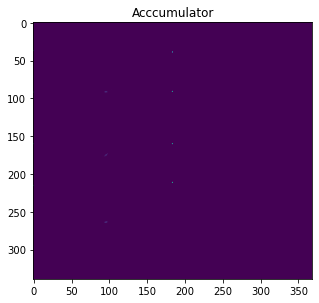

In [6]:
#Plotting the accumulator
plt.figure(figsize=(5, 5))
plt.imshow(acc)
plt.title("Acccumulator")
plt.show()

In [7]:
#The following function is to retrieve indeces of a specific number of peaks out of our accumulator wich maps to the most voted lines.
def houghpeaks(H,numpeaks):
    col = H.shape[1]
    b = H.reshape(-1)
    x = b.argsort()[-1 * numpeaks:][::-1]
    indeces = []
    for i in x:
        indeces += [(i//col, i%col)]
    return indeces

In [8]:
#Just calling the function to get the peaks.
ind = np.array(houghpeaks(acc,11))
y, x = ind.T

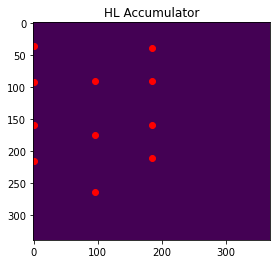

In [9]:
#Plotting the peaks within the accumulator.
plt.imshow(acc)
plt.plot(x, y, 'ro')
plt.title("HL Accumulator")
plt.show()

In [10]:
#The following functoin is to map the indeces to specific rhos and thetas then get the equtions of these lines.
def  houghlines(BW,theta,rho,peaks):
    max_range = BW.shape[1]
    y, x = peaks.T #Just unzipping the x values, column numbers, and y values, row numbers, away from each other.
    
    x_max = BW.shape[0] #The number of rows.
    y_max = BW.shape[1] #The number of columns.
    
    r_max = math.hypot(x_max, y_max) #The maximum value of rhos.
    theta_max = 1.0 * math.pi #The maximum value of thetas.
    r_dim = BW.shape[0]  #Number of steps to map the range of rhos to it(Quantization).
    theta_dim = BW.shape[1] #Number of steps to map the range of thetas to it(Quantization).
    
    line_eq = []
    for i, j in zip(x, y):
        
        r = round( (1.0 * j * r_max ) / r_dim,2) #Mapping the indeces to a specific value of rho.
        thetaa = round( (1.0 * i * theta_max) / theta_dim,2) #Mapping the indeces to a specific value of theta.
        
        #getting the equatoin of the line.
        #The equation used is from the following tutorial, lines in the Polar system.
        # https://docs.opencv.org/3.4/d9/db0/tutorial_hough_lines.html
        line_eq += [((-1 * np.cos(thetaa)/(np.sin(thetaa+2.220446049250313e-16))), (r/(np.sin(thetaa+2.220446049250313e-16))),)]
        
    return line_eq

In [11]:
#Just calling the function to get the lines.
line_eq = houghlines(img, rho, theta, ind)

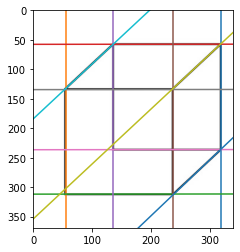

In [12]:
#Plotting the lines wihtin the picture.
plt.imshow(img)
plt.xlim([0, 339])
plt.ylim([369, 0])
x = np.arange(369)
for i in line_eq:
    y = i[0] * x + i[1]
    plt.plot(x, y)